In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

from simulation_code.tissue_model import invision_source
from simulation_code.load_model import load_model_from_excel
from simulation_code.tissues import melanin_absorber

from itertools import product

os.environ["PA_SIM_EXTRAPOLATE"] = "0"

In [2]:
dx = 0.1  # mm
nx, ny, nz = 220, 220, 220

FAST_DEMO_MODE = True

# Wavelengths to get reflectance measurements at.
WAVELENGTHS = np.arange(700, 920, 20)
if FAST_DEMO_MODE:
    WAVELENGTHS = WAVELENGTHS[:1]

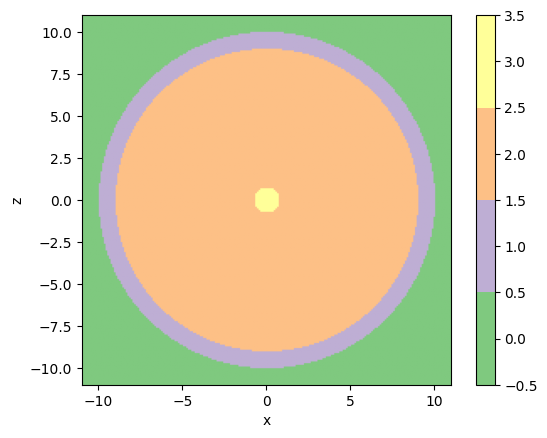

In [3]:
tissue_model_example = load_model_from_excel(
    "simulation_specification/invision_phantom_specification.xlsx", nx, ny, nz, dx
)
tissue_model_example.imshow()
plt.show()

In [4]:
artery_oxygenation = np.linspace(0, 1, 11)
if FAST_DEMO_MODE:
    artery_oxygenation = artery_oxygenation[-1:]
absorptions = [0.00123, 0.447, 0.793, 1.18, 1.84]
mvfs = [x / melanin_absorber(1)(685)[()] for x in absorptions]
if FAST_DEMO_MODE:
    mvfs = mvfs[-1:]

In [6]:
for i, (ox, mvf) in enumerate(tqdm(list(product(artery_oxygenation, mvfs)))):
    settings = {"mvf": mvf, "artery_oxygenation": ox}

    tissue_model = load_model_from_excel(
        "simulation_specification/invision_phantom_specification.xlsx",
        nx,
        ny,
        nz,
        dx,
        variations=[
            ("Epidermis", {"MelanosomeVolumeFraction": mvf}),
            ("Artery", {"BloodOxygenation": ox}),
        ],
    )
    m = tissue_model.run_mcx(
        WAVELENGTHS,
        [invision_source(tissue_model, i) for i in range(10)],
        middle_slice_only=True,
    )
    m.update(settings)
    geometry = np.load("../data/invision_geometry.npz")["geom"]
    if not FAST_DEMO_MODE:
        np.savez(
            f"../data/simulations/invision optical simulation/melanin_allox_{str(i).zfill(3)}",
            **m,
            r0=tissue_model.r_0,
            dx_mm=tissue_model.dx_mm,
            n=tissue_model.n,
            geom=geometry,
        )

  0%|          | 0/1 [00:00<?, ?it/s]

###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2022 Qianqian Fang <q.fang at neu.edu>          #
#                             http://mcx.space/                               #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
$Rev::      $v2022.10$Date::                       $ by $Author::             $
###############################################################################
- variant name: [Fermi] compiled by nvcc